# Text Analytics - Assignment 1

**Group Members** - 
1. Sagar Chadha
2. Ryan Hoff
3. Cory Nguyen
4. Akhilesh Reddy
5. Lu-Hao Kuo

In [1]:
# import libraries
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
%matplotlib inline

import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in the train_rev1 datafile downloaded from kaggle
df = pd.read_csv('Train_rev1.csv')
df.head(2)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk


In [3]:
# randomly sample 2500 rows from the data
import random
random.seed(1)
indices = df.index.values.tolist()

random_2500 = random.sample(indices, 2500)

random_2500[:5]

[35222, 149213, 222149, 210308, 200218]

In [4]:
# subset the imported data on the selected 2500 indices
train = df.loc[random_2500, :]
train = train.reset_index(drop = True)
train.head(2)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,68234454,Bar & Leisure Supervisor,Genting Casinos UK is looking for an experienc...,Leicester Leicestershire East Midlands,Leicester,NaN,NaN,Genting UK,Hospitality & Catering Jobs,"Up to 17,000 per annum",17000,caterer.com
1,70762305,Principal Development Engineer,Principal Development Engineer RF Microwave /...,Scotland,Scotland,NaN,permanent,ATA Recruitment,Engineering Jobs,38000 - 45000/annum + 38k - 45k (DOE) + Pensio...,41500,cv-library.co.uk


In [5]:
# some problems with the way FullDescription has been encoded
def convert_utf8(s):
    return str(s)

train['FullDescription'] = train['FullDescription'].map(convert_utf8)

Approach - 
1. Lets first make a corpus of all the descriptions provided to us.
2. From this corpus, we will pick up anomalies in the descriptions - urls, numbers, etc. that are of no use to us in terms of predictions.
3. We will make lists of these anomalous strings.
4. Going back to our dataset, we will clean the descriptions by removing these anomalous strings from the job descriptions

In [6]:
# make a corpus of all the words in the job description
corpus = ". ".join(train['FullDescription'].tolist())

# tokenize the corpus to get individual words
tokens = word_tokenize(corpus)

### Cleaning up the corpus

We notice the following  a lot of urls in the text corpus. We should remove these before proceeding.
Urls would usually have 'co.uk' in them or '.com' in them.

In [7]:
# find all urls in the data
weblinks = [w for w in tokens if ".co.uk" in w]
weblinks = weblinks + [w for w in tokens if ".com" in w] + [w for w in tokens if "www." in w]
weblinks = list(set(weblinks))

# We also notice a lot of words with '*' characters in them. These are sometimes salary figures that have been hidden to 
# keep the prediction problem meaningful. Other times its just useless strings.
def find_numbers(s):
    found = []
    if len(re.findall('.*[0-9]+.*', s)) > 0:
        found.append(re.findall('.*[0-9]+.*', s)[0])
        return found[0]
    else:
        return np.nan
    
numbers = pd.Series(tokens).map(find_numbers)
numbers = numbers[~numbers.isnull()]

# there are strings with a lot of '*' in them. We need to remove these.
def find_stars(s):
    found = []
    if len(re.findall('.*[\*]+.*', s)) > 0:
        found.append(re.findall('.*[\*]+.*', s)[0])
        return found[0]
    else:
        return 0

star_words = pd.Series(tokens).map(find_stars)
star_words = star_words[star_words != 0].tolist()

We have used the corpus to find out star words, urls, numbers, etc. in the text. We need to remove these from the fulldescription column.
1. Remove the urls first

In [8]:
def remove_urls(s):
    global weblinks
    for i in weblinks:
        s = s.replace(i, "")
    return s

train['Clean_Full_Descriptions'] = train['FullDescription'].map(remove_urls)

2. Remove the star_words

In [9]:
def remove_star_words(s):
    global star_words
    for i in star_words:
        s = s.replace(i, "")
    return s

train['Clean_Full_Descriptions'] = train['Clean_Full_Descriptions'].map(remove_star_words)

3. Remove numbers

In [10]:
def remove_nums(s):
    global numbers
    for i in numbers:
        s = s.replace(i, "")
    return s

train['Clean_Full_Descriptions'] = train['Clean_Full_Descriptions'].map(remove_nums)

4. Remove the punctuations

In [11]:
from string import punctuation

def remove_punctuation(s):
    global punctuation
    for p in punctuation:
        s = s.replace(p, '')
    return s

train['Clean_Full_Descriptions'] = train['Clean_Full_Descriptions'].map(remove_punctuation)

5. Convert to lower case

In [12]:
train['Clean_Full_Descriptions'] = train['Clean_Full_Descriptions'].map(lambda x: x.lower())

The `Clean_Full_Descriptions` has the full descriptions without punctuations, numbers, star words or urls!

# Part A
## Question A1 - 
###  Part 1 - What are the top 5 parts of speech in the job description? How frequently do they appear? 

### Answer
We see that the most frequent parts of speech are -
1. Noun (NN) - 156589
2. Adjectives(JJ) - 70047
3. Preposition (IN) - 65702
4. Plural nouns(NNS) - 51286
5. Determiner (DT) - 50691

Approach - 
1. Tokenize each description under the clean_full_description column.
2. For each description get the parts of speech tagging for each string in the full description

In [13]:
# define a function for parts of speech tagging
def pos_tagger(s):
    """For a given text description, tokenize the words in it, tag parts of speech and return just the tag"""
    answer = []
    text = word_tokenize(s)
    answer.append(nltk.pos_tag(text))
    answer_pos = [w for a in answer for (v,w) in a]
    return answer_pos

# map parts of speech to each description
pos = train['Clean_Full_Descriptions'].map(pos_tagger)

# get a list of all parts of speech found
all_pos = []

for a in pos:
    for b in a:
        all_pos.append(b)

all_pos = pd.Series(all_pos)
all_pos.value_counts().head()

NN     156627
JJ      70054
IN      65701
NNS     51287
DT      50691
dtype: int64

### Part 2 - How does the frequency change if we exclude stopwords?

### Answer
We see that the most frequent parts of speech are -
1. Noun (NN) - 151635
2. Adjectives(JJ) - 72284
3. Noun plural (NNS) - 50497
4. Verb/Gerund(VBG) - 25118
5. Verb/Present Participle (VBP) - 17218

Approach -
1. Remove stopwords from each of the descriptions.
2. apply the pos_tagger again.

In [14]:
# store english stopwords in a list
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

# define a function to remove stopwords from descriptions
def remove_stopwords(s):
    global en_stopwords
    s = word_tokenize(s)
    s = " ".join([w for w in s if w not in en_stopwords])
    return s

# Create a new column of descriptions with no stopwords
train['Clean_Full_Descriptions_no_stop'] = train['Clean_Full_Descriptions'].map(remove_stopwords)

# get parts of speech
pos = train['Clean_Full_Descriptions_no_stop'].map(pos_tagger)

# get a list of all parts of speech found
all_pos = []

for a in pos:
    for b in a:
        all_pos.append(b)

all_pos = pd.Series(all_pos)
all_pos.value_counts().head()

NN     151689
JJ      72293
NNS     50497
VBG     25123
VBP     17219
dtype: int64

## Question A2 - 
### Does this data support Zipf's law? Plot the 100 most common words in the data against the theoretical prediction of the law.

Approach - 
1. Create a corpus of the cleaned descriptions.
2. Tokenize the words in the corpus.
3. Take a count of these words.

### Answer -
Yes the data supports Zipf's law based on the top 100 most frequently occuring words. The theta value obtained from fitting the OLS on the log(frequency) to predict log(rank) is -1.03 which is close to -1.

In [15]:
# prepare corpus from the descriptions that still have stopwords
corpus = " ".join(train['Clean_Full_Descriptions'].tolist())

#tokenize words
tokenized_corpus = nltk.word_tokenize(corpus)
fd = nltk.FreqDist(tokenized_corpus)

# get the top words
top_words = []
for key, value in fd.items():
    top_words.append((key, value))

# sort the list by the top frequencies
top_words = sorted(top_words, key = lambda x:x[1], reverse = True)

# keep top 100 words only
top_words = top_words[:100]

# Keep the frequencies only from the top word series
top_word_series = pd.Series([w for (v,w) in top_words])
top_word_series[:5]

# get actual ranks of these words - wherever we see same frequencies, we give same rank
word_ranks = top_word_series.rank(method = 'min', ascending = False)

The value of theta obtained is: [-1.03049236]


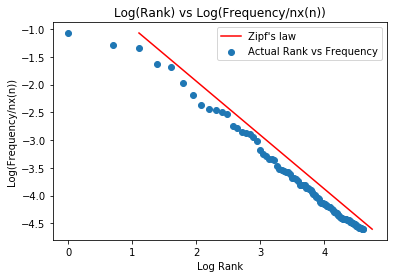

In [16]:
# Run a regression on this
denominator = max(word_ranks)*min(top_word_series)

Y = np.array(np.log(word_ranks))
X = np.array(np.log(top_word_series/denominator))

from sklearn import linear_model
reg_model = linear_model.LinearRegression(fit_intercept = False)

reg_model.fit(Y.reshape(-1,1), X)
print("The value of theta obtained is:",reg_model.coef_)

# make a plot of actual vs theory
plt.scatter(Y, X, label = "Actual Rank vs Frequency")
plt.title('Log(Rank) vs Log(Frequency/nx(n))')
plt.xlabel('Log Rank')
plt.ylabel('Log(Frequency/nx(n))')

plt.plot(reg_model.predict(X.reshape(-1,1)), X, color = 'red', label = "Zipf's law")
plt.legend()

## Question A3 - 
### If we remove stopwords and lemmatize the data, what are the 10 most common words? What are their frequencies?

### Answer - 
The top 10 words are - 
1. Experience - 4336
2. Role - 3236
3. team - 3018
4. Work - 3015
5. Client - 2859
6. Business - 2857
7. Skill - 2495
8. Service - 2401
9. Working - 2271
10. Sale - 2234

In [17]:
# import the necessary functions from the nltk library
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

# prepare corpus from the descriptions that still have stopwords
corpus = " ".join(train['Clean_Full_Descriptions_no_stop'].tolist())

#tokenize words
tokenized_corpus = nltk.word_tokenize(corpus)

# lemmatize
lemmatized_tokens = [lmtzr.lemmatize(token) for token in tokenized_corpus]

# word frequencies for the lemmatized tokens
fd = nltk.FreqDist(lemmatized_tokens)

# get the top words
top_words = []
for key, value in fd.items():
    top_words.append((key, value))

# sort the list by the top frequencies
top_words = sorted(top_words, key = lambda x:x[1], reverse = True)

# keep top 100 words only
top_words = top_words[:10]

top_words

[('experience', 4336),
 ('role', 3236),
 ('team', 3018),
 ('work', 3015),
 ('client', 2859),
 ('business', 2857),
 ('skill', 2495),
 ('service', 2401),
 ('working', 2271),
 ('sale', 2234)]

# Part B
## Question B1
### Predict high (>75th percentile)/low (< 75th percentile) salary from just the numeric variables in the data.

`SalaryNormalized` has the salary values for each job description

In [18]:
# get the 75th percentile value of salary!
sal_perc_75 = np.percentile(train['SalaryNormalized'], 75)

# make a new target variable that captures whether salary is high (1) or low (0)
train['Salary_Target'] = np.where(train['SalaryNormalized'] >= sal_perc_75, 1, 0)

Most values in our dataframe are of the 'Object' or 'String' data type. This means that we will have to convert these to dummy variables to proceed!

Let's first check for missing values in the data!

In [19]:
train.isnull().sum()[train.isnull().sum()>0]

ContractType    1851
ContractTime     653
Company          328
dtype: int64

There are missing values in the variables as shown above! These are all 'character' variables so when we create dummies, there will be a new column for the 'NA' values.

#### Get a list of expensive cities in England

In [20]:
exp_cities = ['London', 'Oxford', 'Brighton', 'Cambridge', 'Bristol', 'Portsmouth', 'Reading', 'Edinburgh', 'Leicester',
             'York', 'Exeter']

train['Exp_Location'] = np.where(train['LocationNormalized'].map(lambda x: x in exp_cities), 1, 0)

### Naive Bayes using Numerical variables

In [21]:
# Subset the columns required
columns_required = ['ContractType', 'ContractTime', 'Company', 'Category', 'SourceName', 'Exp_Location', 'Salary_Target']

train_b1 = train.loc[:, columns_required]

# Convert the categorical variables to dummy variables
train_b1 = pd.get_dummies(train_b1)

# Lets separate the predictors from the target variable
columns_selected = train_b1.columns.values.tolist()
target_variable = ['Salary_Target']

predictors = list(set(columns_selected) - set(target_variable))

# setup the model
from sklearn.naive_bayes import BernoulliNB

X = np.array(train_b1.loc[:,predictors])
y = np.array(train_b1.loc[:,target_variable[0]])

# create test train splits 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

model = BernoulliNB()

# Fit the model and predict the output on the test data
model.fit(X_train, y_train)

# Predicted output
predicted = model.predict(X_test)

# Accuracy
from sklearn import metrics

print("Model Accuracy is:", metrics.accuracy_score(y_test, predicted))
print("Area under the ROC curve:", metrics.roc_auc_score(y_test, predicted))
print("Confusion Matrix:\n",metrics.confusion_matrix(y_test, predicted))

Model Accuracy is: 0.78
Area under the ROC curve: 0.589823330907166
Confusion Matrix:
 [[363  18]
 [ 92  27]]


### Answer -
#### The prediction accuracy achieved is 78% using just the numerical variables!

### Multinomial Naive Bayes using job descriptions

In [22]:
# Lets lemmatize the job descriptions before we run the model
def text_lemmatizer(s):
    tokenized_corpus = nltk.word_tokenize(s)
    
    # lemmatize
    s = " ".join([lmtzr.lemmatize(token) for token in tokenized_corpus])
    return s

train['Clean_Full_Descriptions_no_stop_lemm'] = train['Clean_Full_Descriptions_no_stop'].map(text_lemmatizer)

X = np.array(train.loc[:, 'Clean_Full_Descriptions_no_stop_lemm'])
y = np.array(train.loc[:, 'Salary_Target'])

# split into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

# Convert the arrays into a presence/absence matrix
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

from sklearn.naive_bayes import MultinomialNB
nb_mult_model = MultinomialNB().fit(X_train_counts, y_train)
predicted = nb_mult_model.predict(X_test_counts)

print("Model Accuracy:", metrics.accuracy_score(y_test, predicted))
print("Area under the ROC curve:", metrics.roc_auc_score(y_test, predicted))
print("Model Confusion Matrix:\n", metrics.confusion_matrix(y_test, predicted))

Model Accuracy: 0.826
Area under the ROC curve: 0.7673636383687333
Model Confusion Matrix:
 [[335  46]
 [ 41  78]]


### Bernoulli Naive Bayes using Job Descriptions

In [23]:
# Calculate the frequencies of words using the TfidfTransformer
X_train_bern = np.where(X_train_counts.todense() > 0 , 1, 0)
X_test_bern = np.where(X_test_counts.todense() > 0, 1, 0)

# Fit the model
from sklearn.naive_bayes import BernoulliNB
nb_bern_model = BernoulliNB().fit(X_train_bern, y_train)
predicted = nb_bern_model.predict(X_test_bern)

# print the accuracies
print("Model Accuracy:", metrics.accuracy_score(y_test, predicted))
print("Area under the ROC curve:", metrics.roc_auc_score(y_test, predicted))
print("Model Confusion Matrix:\n", metrics.confusion_matrix(y_test, predicted))

Model Accuracy: 0.792
Area under the ROC curve: 0.6208121043693068
Model Confusion Matrix:
 [[361  20]
 [ 84  35]]


### Words that indicate high/low salary

In [24]:
# extract the column names for the columns in our training dataset.
column_names = [x for (x,y) in sorted(count_vectorizer.vocabulary_.items(), key = lambda x:x[1])]

# probability of high salary
p_1 = np.mean(y_train)

# probability of low salary
p_0 = 1 - p_1

# create an array of feature vectors
feature_vectors = np.array(X_train_bern)

# probability of word appearance
word_probabilities = np.mean(feature_vectors, axis = 0)

# probability of seeing these words for class= 1 and class = 0 respectively
p_x_1 = np.mean(feature_vectors[y_train==1, :], axis = 0)
p_x_0 = np.mean(feature_vectors[y_train==0, :], axis = 0)

# words that are good indicators of high salary (class = 1)
high_indicators = p_x_1 * (np.log2(p_x_1) - np.log2(word_probabilities) - np.log2(p_1))

high_indicators_series = pd.Series(high_indicators, index = column_names)

# words that are good indicators of low salary (class = 0)
low_indicators = p_x_0 * (np.log2(p_x_0) - np.log2(word_probabilities) - np.log2(p_0))

low_indicators_series = pd.Series(low_indicators, index = column_names)

### Get words indicative of low salary
The numbers against the terms show the mutual information of these words with the low salary output

In [25]:
low_indicators_series[[i for i in low_indicators_series.index if i not in en_stopwords]].sort_values(ascending = False)[:10].index

Index(['experience', 'work', 'role', 'client', 'working', 'team', 'please',
       'job', 'looking', 'skill'],
      dtype='object')

### Get words indicative of high salary
The numbers against the terms show the mutual information of these words with the low salary output

In [26]:
high_indicators_series[[i for i in high_indicators_series.index if i not in en_stopwords]].sort_values(ascending = False)[:10].index

Index(['experience', 'role', 'team', 'business', 'opportunity', 'management',
       'skill', 'client', 'work', 'project'],
      dtype='object')

## Question B3 - 
### Train a hybrid model to predict high/low salary using both numeric and text data. 
Show the accuracy of the model

### Answer - 
The accuracy of the model is 78.4%. Yes, given that just text descriptions give us 82.6% accuracy, we would have expected the hybrid model to outperform this but it didnt!

We choose the text only model since it gives us the best accuracy out of sample!

In [27]:
# convert text data to dataframe
X = np.array(train.loc[:, 'Clean_Full_Descriptions_no_stop_lemm'])

count_vectorizer = CountVectorizer()
X_counts = count_vectorizer.fit_transform(X)

column_names = [x for (x,y) in sorted(count_vectorizer.vocabulary_.items(), key = lambda x:x[1])]
X_counts_to_occurence = np.where(X_counts.todense() > 0, 1, 0)

text_data = pd.DataFrame(X_counts_to_occurence, columns = column_names)

# train_b1 has the numerical data we used earlier
# Lets separate the predictors from the target variable
columns_selected = train_b1.columns.values.tolist() + text_data.columns.values.tolist()

target_variable = ['Salary_Target']

predictors = list(set(columns_selected) - set(target_variable))

full_data = pd.concat([train_b1, text_data], axis = 1)

X = np.array(full_data.loc[:,predictors])
y = np.array(full_data.loc[:,target_variable[0]])

# create test train splits 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

model = BernoulliNB()

# Fit the model and predict the output on the test data
model.fit(X_train, y_train)

# Predicted output
predicted = model.predict(X_test)

# Accuracy
from sklearn import metrics

print("Model Accuracy is:", metrics.accuracy_score(y_test, predicted))
print("Area under the ROC curve:", metrics.roc_auc_score(y_test, predicted))
print("Confusion Matrix:\n",metrics.confusion_matrix(y_test, predicted))

Model Accuracy is: 0.784
Area under the ROC curve: 0.6328988288228679
Confusion Matrix:
 [[351  30]
 [ 78  41]]
